In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import sklearn

In [3]:
import regressor
import utils

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [5]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [6]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [8]:
object_ids = np.unique(data.object_id)

In [9]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [10]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [11]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [12]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [13]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    new_object = add_log_lam(new_object)
    return new_object

In [14]:
def is_good(anobject):
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return False
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        return False
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        return False
    
    return True

In [15]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

34299


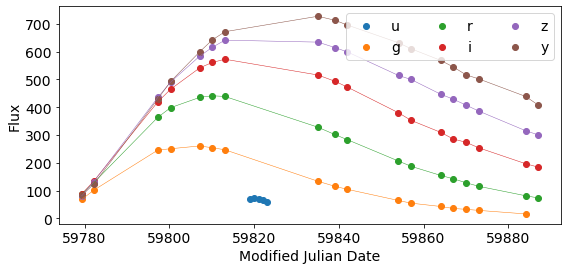

43812


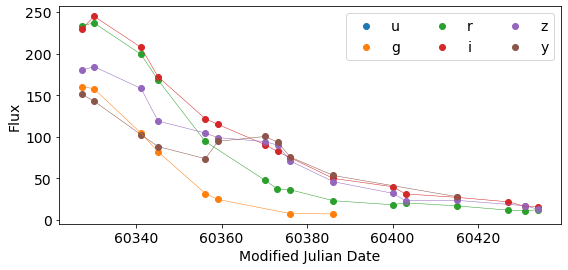

70046


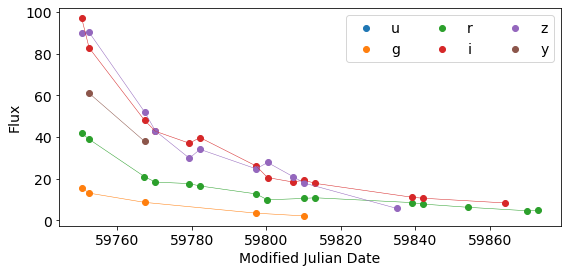

84716


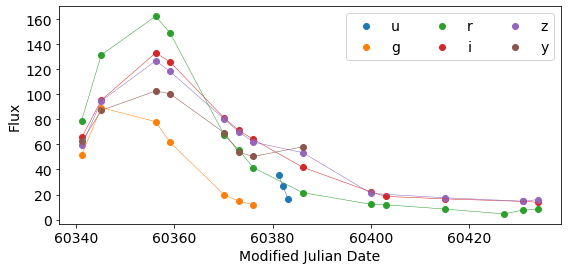

131629


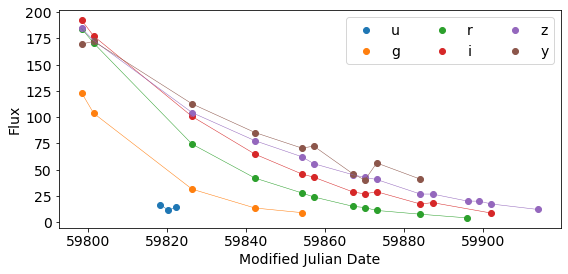

169315


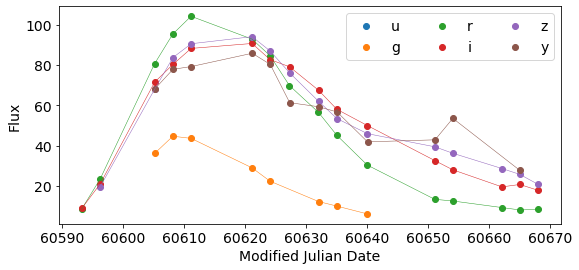

229855


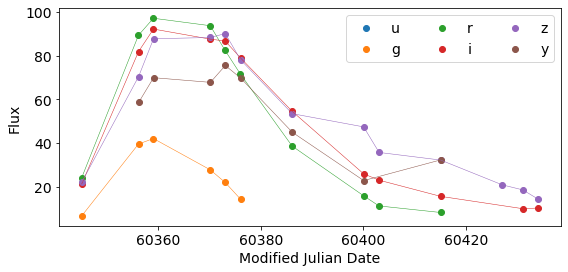

251430


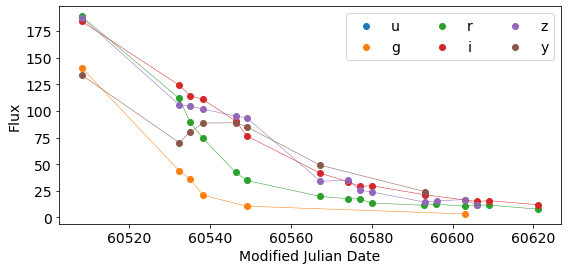

282714


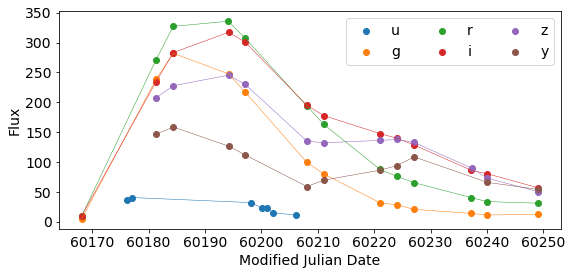

290682


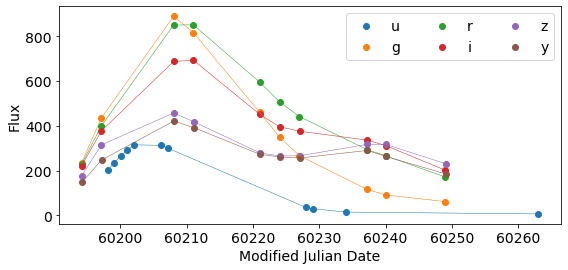

316306


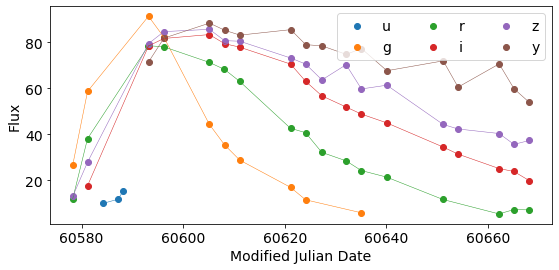

In [16]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# One object test Test

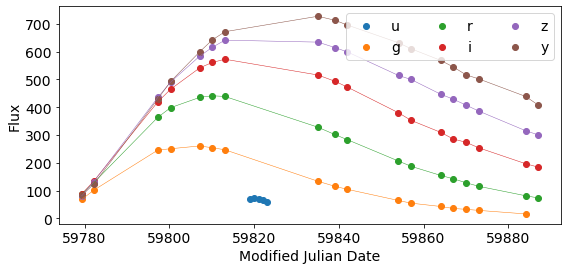

In [30]:
anobject = get_object(data, 34299)
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
plt.savefig('light_curve_34299.pdf', format='pdf')

In [31]:
MODEL = "NN"

In [76]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.4, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_test  = anobject_test['flux'].values

from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
X_train_ss = ss_x.fit_transform(X_train)
X_test_ss = ss_x.transform(X_test)

ss_y = StandardScaler()
y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))
y_test_ss = ss_y.transform(y_test.reshape((-1, 1)))


# fit a regression model to approximate light curves
if MODEL == "XGB":
    from xgboost import XGBRegressor
    reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
elif MODEL == "NN":
    reg = regressor.FitNNRegressor(n_hidden=300, n_epochs=200, batch_size=1, lr=0.01, lam=0.01, optimizer='SGD')
elif MODEL == "Linear":
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression()
elif MODEL == "GP":
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
    kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
    reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5, optimizer="fmin_l_bfgs_b", random_state=42)

reg.fit(X_train_ss, y_train_ss)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
res = ss_y.inverse_transform(reg.predict(X_test_ss))
anobject_test_pred['flux'] = np.maximum(res, np.zeros(len(res)))

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
res = ss_y.inverse_transform(reg.predict(X_train_ss))
anobject_train_pred['flux'] = np.maximum(res, np.zeros(len(res)))

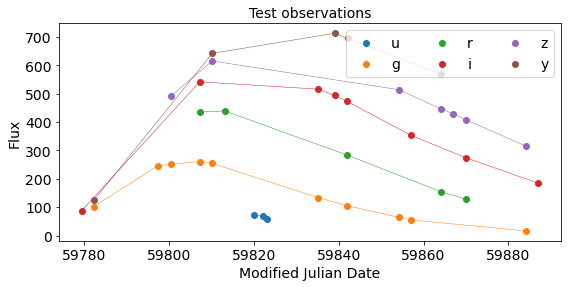

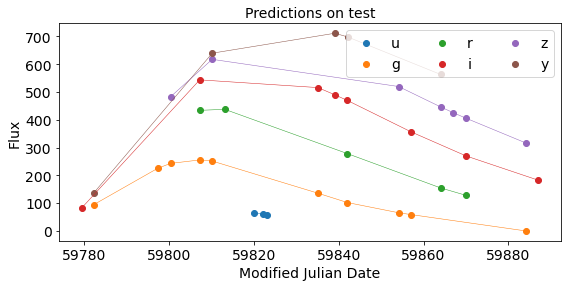

In [77]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

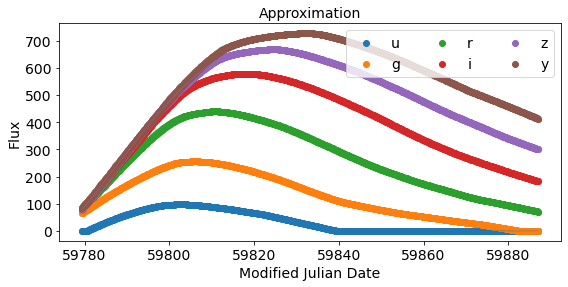

In [78]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss_x.transform(X)
res = ss_y.inverse_transform(reg.predict(X_ss))
approx_object['flux'] = np.maximum(res, np.zeros(len(res)))
plot_light_curves(approx_object, "Approximation")
plt.savefig('approx_light_curve_34299.pdf', format='pdf')

In [79]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  6.082828326201257
MAE:  4.352141218113945
RSE:  0.029961281270210464
RAE:  0.024317179470686307
MAPE:  4.92871382369132


# Test on many objects

In [23]:
good_objects = []
for i in object_ids:
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    if is_good(anobject):
        good_objects.append(anobject)

In [108]:
from tqdm import tqdm
from tqdm import tqdm_notebook

report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in tqdm_notebook(range(len(good_objects))):
    # get an object
    anobject = good_objects[i]
    
    if not is_good(anobject): continue
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=1/3, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)
    
    ss_y = StandardScaler()
    y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))
    y_test_ss = ss_y.transform(y_test.reshape((-1, 1)))

    # fit a regression model to approximate light curves
    if MODEL == "XGB":
        from xgboost import XGBRegressor
        reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
    elif MODEL == "NN":
        reg = regressor.FitNNRegressor(n_hidden=300, n_epochs=200, batch_size=1, lr=0.01, lam=0.01, optimizer='SGD')
    elif MODEL == "Linear":
        from sklearn.linear_model import LinearRegression
        reg = LinearRegression()
    elif MODEL == "GP":
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
        kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
        reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, optimizer="fmin_l_bfgs_b", random_state=42)

    reg.fit(X_train_ss, y_train_ss)
    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    res = ss_y.inverse_transform(reg.predict(X_test_ss))
    anobject_test_pred['flux'] = np.maximum(res, np.zeros(len(res)))
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                      anobject_test_pred['flux'].values)
    report.loc[len(report), :] = [i] + list(metrics)    

In [109]:
np.round(report.mean(), 2)

ID      257.50
RMSE     20.99
MAE      13.07
RSE       0.20
RAE       0.17
MAPE     15.41
dtype: float64

In [110]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,0,5.21153,3.99224,0.112163,0.119594,17.2938
1,1,3.61724,2.61883,0.0896064,0.0865881,13.0024
2,2,11.9119,8.79504,0.169008,0.149618,24.0773
3,3,13.5688,6.99171,0.164613,0.151681,14.0926
4,4,3.33689,2.4664,0.0760495,0.0666868,5.63218
...,...,...,...,...,...,...
511,511,3.74649,2.58969,0.270871,0.217172,11.1617
512,512,6.59343,4.87456,0.223915,0.196733,7.83229
513,513,6.48469,4.18837,0.194313,0.148357,11.5397
514,514,46.7386,31.3195,0.393531,0.289715,51.0507
